In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score, 
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import label_binarize
import pickle
from itertools import cycle

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# Load best model
with open('../models/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Load scaler
with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load label encoder
with open('../models/risk_mapping.pkl', 'rb') as f:
    risk_mapping = pickle.load(f)

# Load feature names
with open('../models/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

# Load test data
X_test = np.load('../data/processed_data/X_test_scaled.npy')
y_test = np.load('../data/processed_data/y_test.npy')


print(f"Best model: {type(best_model).__name__}")
print(f"Test set size: {X_test.shape}")
print(f"Classes: {list(risk_mapping.keys())}")

Best model: RandomForestClassifier
Test set size: (203, 6)
Classes: ['low risk', 'mid risk', 'high risk']


In [4]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print("Predictions generated!")
print(f"Predictions shape: {y_pred.shape}")
print(f"Probabilities shape: {y_pred_proba.shape}")

Predictions generated!
Predictions shape: (203,)
Probabilities shape: (203, 3)


In [5]:
print("="*80)
print("OVERALL MODEL PERFORMANCE")
print("="*80)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Create summary
metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Score': [accuracy, precision_weighted, recall_weighted, f1_weighted]
})

print(metrics_summary)
print(f"\n🎯 Overall Accuracy: {accuracy*100:.2f}%")

OVERALL MODEL PERFORMANCE
                 Metric     Score
0              Accuracy  0.852217
1  Precision (Weighted)  0.851994
2     Recall (Weighted)  0.852217
3   F1-Score (Weighted)  0.851440

🎯 Overall Accuracy: 85.22%


In [6]:
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)

reverse_mapping = {v: k for k, v in risk_mapping.items()}

class_names = [reverse_mapping[i] for i in sorted(reverse_mapping)]



# Generate report
report = classification_report(y_test, y_pred, 
                              target_names=class_names,
                              digits=4)
print(report)

# Convert to DataFrame for saving
from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_pred, 
                                   target_names=class_names,
                                   output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('../output/classification_report.csv')

print("\nClassification report saved!")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    low risk     0.8684    0.8148    0.8408        81
    mid risk     0.7941    0.8060    0.8000        67
   high risk     0.8983    0.9636    0.9298        55

    accuracy                         0.8522       203
   macro avg     0.8536    0.8615    0.8569       203
weighted avg     0.8520    0.8522    0.8514       203


Classification report saved!


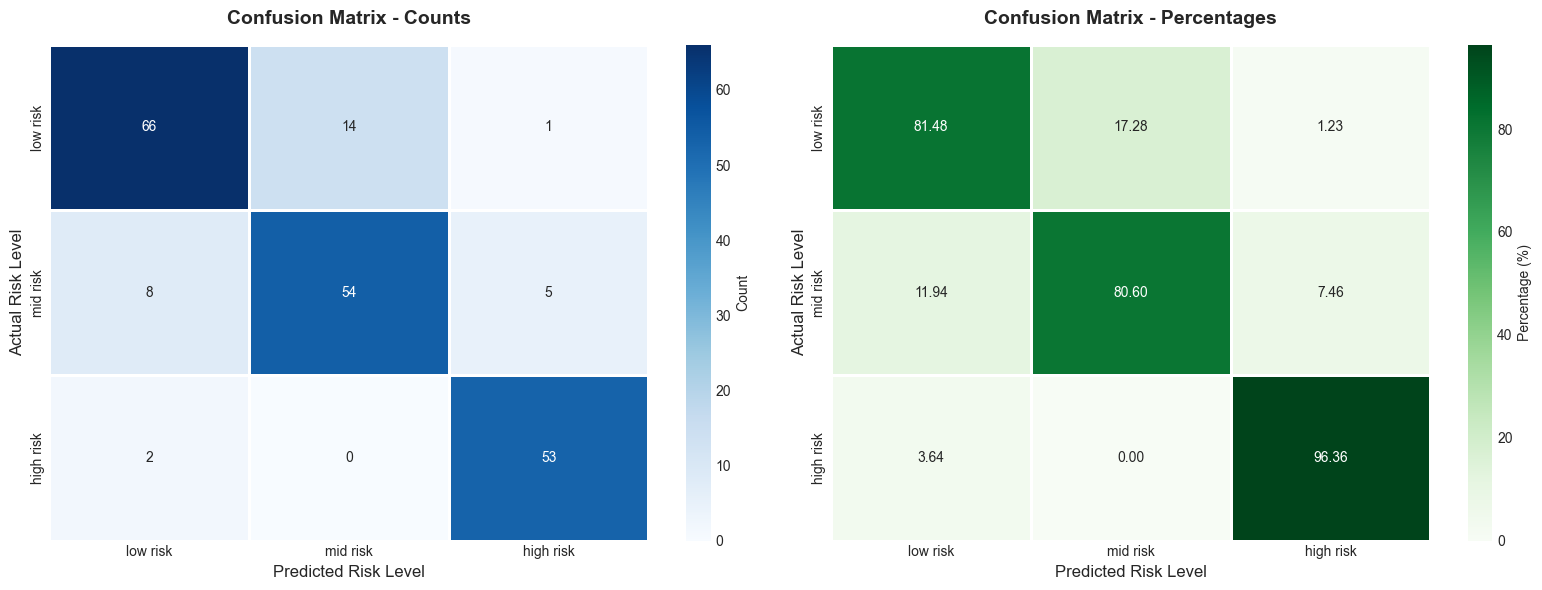

✅ Detailed confusion matrix saved!


In [7]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create detailed plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Count-based confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='white',
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Actual Risk Level', fontsize=12)
axes[0].set_xlabel('Predicted Risk Level', fontsize=12)

# Plot 2: Percentage-based confusion matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Percentage (%)'},
            linewidths=2, linecolor='white',
            ax=axes[1])
axes[1].set_title('Confusion Matrix - Percentages', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Actual Risk Level', fontsize=12)
axes[1].set_xlabel('Predicted Risk Level', fontsize=12)

plt.tight_layout()
plt.savefig('../output/visualizations/confusion_matrix_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Detailed confusion matrix saved!")

PER-CLASS PERFORMANCE ANALYSIS
       Class  Precision    Recall  F1-Score  Support
0   low risk   0.868421  0.814815  0.840764       81
1   mid risk   0.794118  0.805970  0.800000       67
2  high risk   0.898305  0.963636  0.929825       55


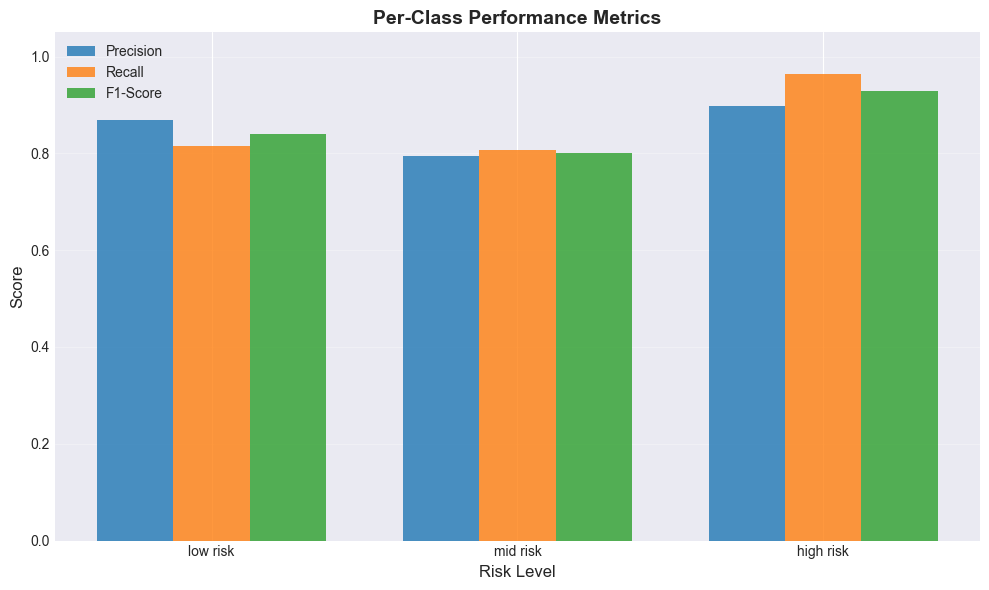


Per-class analysis saved!


In [8]:
print("="*80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("="*80)

# Calculate per-class metrics
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Create DataFrame
class_performance = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': cm.sum(axis=1)
})

print(class_performance)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, class_performance['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x, class_performance['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x + width, class_performance['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Risk Level', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(fontsize=10)
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/visualizations/per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPer-class analysis saved!")

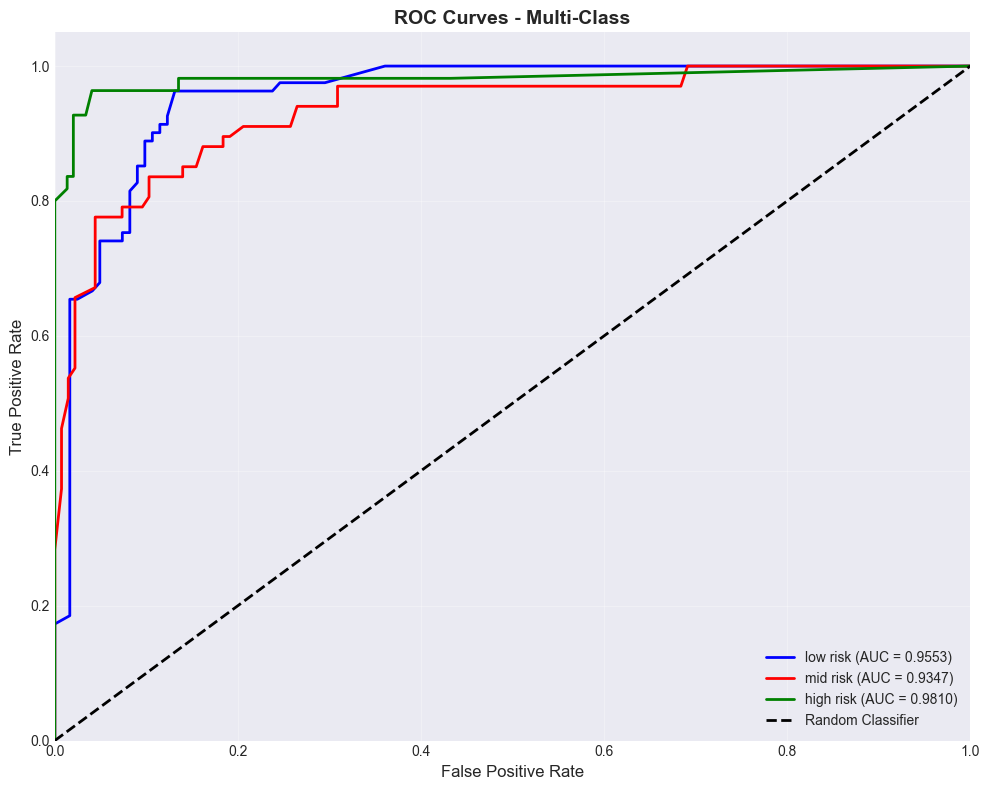

✅ ROC curves saved!

ROC-AUC Scores:
  low risk: 0.9553
  mid risk: 0.9347
  high risk: 0.9810


In [9]:
# Binarize the output for multi-class ROC
n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../output/visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curves saved!")
print(f"\nROC-AUC Scores:")
for i, name in enumerate(class_names):
    print(f"  {name}: {roc_auc[i]:.4f}")

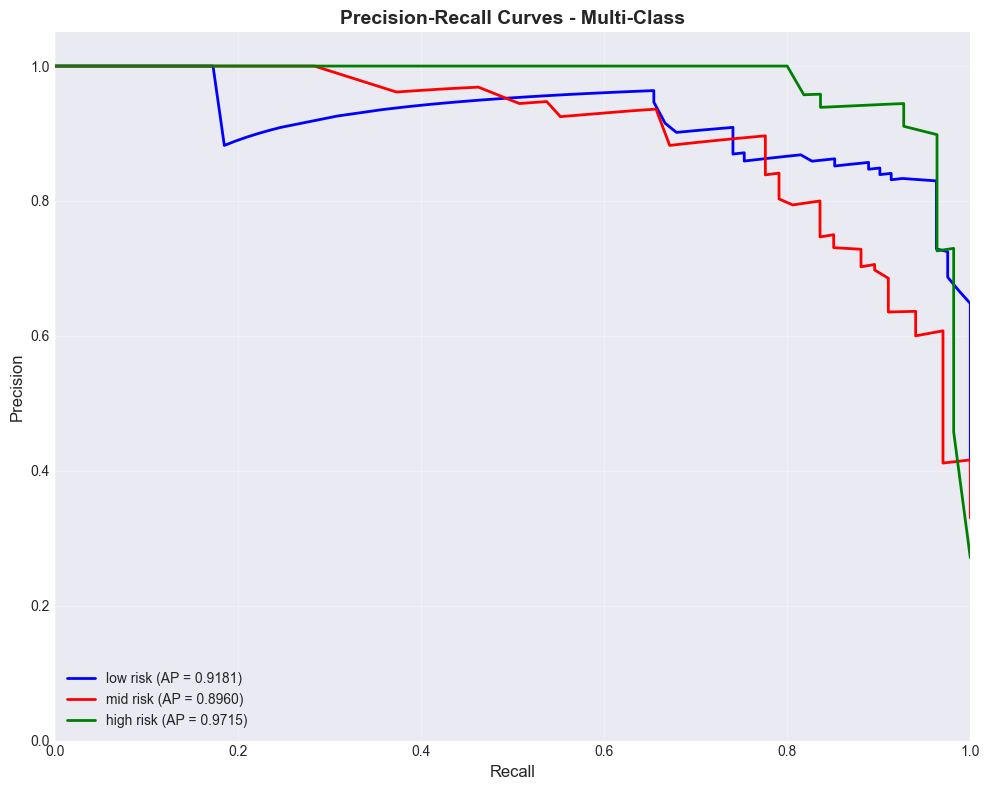

✅ Precision-Recall curves saved!

Average Precision Scores:
  low risk: 0.9181
  mid risk: 0.8960
  high risk: 0.9715


In [10]:
# Compute Precision-Recall curve for each class
precision_dict = dict()
recall_dict = dict()
avg_precision = dict()

for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(
        y_test_bin[:, i], y_pred_proba[:, i]
    )
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall_dict[i], precision_dict[i], color=color, lw=2,
             label=f'{class_names[i]} (AP = {avg_precision[i]:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Multi-Class', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('../output/visualizations/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Precision-Recall curves saved!")
print(f"\nAverage Precision Scores:")
for i, name in enumerate(class_names):
    print(f"  {name}: {avg_precision[i]:.4f}")

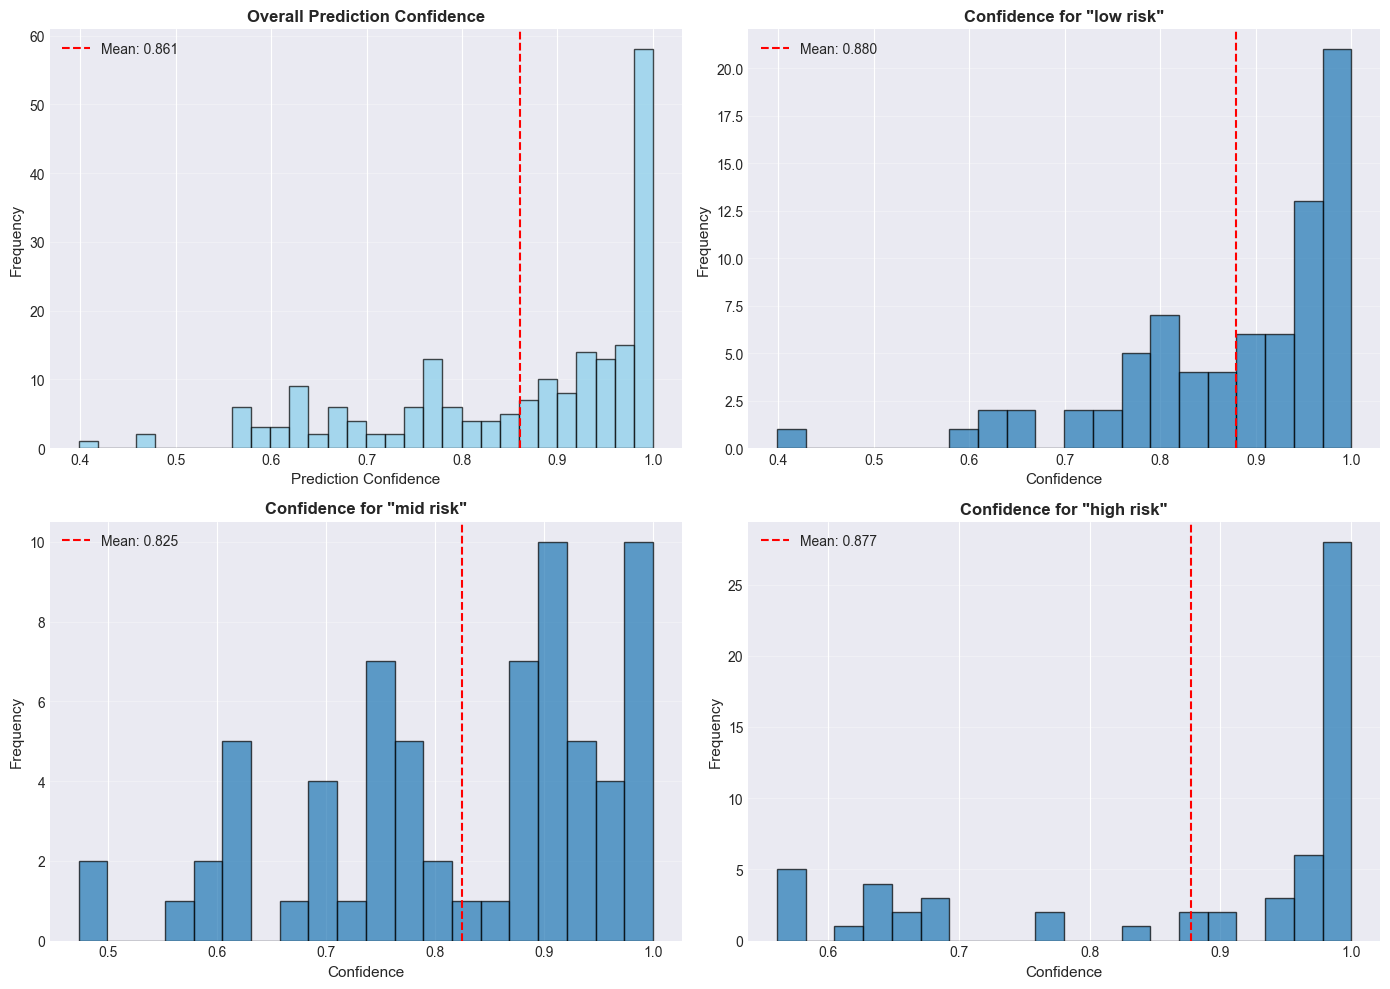

✅ Confidence analysis saved!


In [11]:
# Analyze prediction confidence by class
max_probas = y_pred_proba.max(axis=1)
predicted_classes = y_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall confidence distribution
axes[0, 0].hist(max_probas, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
axes[0, 0].axvline(max_probas.mean(), color='red', linestyle='--', 
                   label=f'Mean: {max_probas.mean():.3f}')
axes[0, 0].set_xlabel('Prediction Confidence', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Overall Prediction Confidence', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Confidence by predicted class
for i, class_name in enumerate(class_names):
    class_mask = predicted_classes == i
    class_confidences = max_probas[class_mask]
    
    if len(class_confidences) > 0:
        if i < 2:
            ax = axes[0, 1] if i == 0 else axes[1, 0]
        else:
            ax = axes[1, 1]
        
        ax.hist(class_confidences, bins=20, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Confidence', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Confidence for "{class_name}"', fontsize=12, fontweight='bold')
        ax.axvline(class_confidences.mean(), color='red', linestyle='--',
                  label=f'Mean: {class_confidences.mean():.3f}')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/visualizations/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confidence analysis saved!")

In [13]:
print("="*80)
print("ERROR ANALYSIS")
print("="*80)

# Find misclassified samples
misclassified_mask = y_test != y_pred
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassifications: {misclassified_mask.sum()}")
print(f"Error rate: {misclassified_mask.sum() / len(y_test) * 100:.2f}%")

# Analyze misclassifications by class
print("\nMisclassifications by Actual Class:")
for i, class_name in enumerate(class_names):
    actual_class_mask = y_test == i
    misclass_in_class = np.logical_and(misclassified_mask, actual_class_mask).sum()
    total_in_class = actual_class_mask.sum()
    
    if total_in_class > 0:
        error_rate = misclass_in_class / total_in_class * 100
        print(f"  {class_name}: {misclass_in_class}/{total_in_class} ({error_rate:.2f}%)")

# Show some examples of misclassifications
if len(misclassified_indices) > 0:
    print("\nFirst 10 Misclassification Examples:")
    misclass_examples = pd.DataFrame({
        'Index': misclassified_indices[:10],
        'Actual': [reverse_mapping[y] for y in y_test[misclassified_indices[:10]]],
        'Predicted': [reverse_mapping[y] for y in y_pred[misclassified_indices[:10]]],
        'Confidence': max_probas[misclassified_indices[:10]]
    })
    print(misclass_examples)


ERROR ANALYSIS
Total misclassifications: 30
Error rate: 14.78%

Misclassifications by Actual Class:
  low risk: 15/81 (18.52%)
  mid risk: 13/67 (19.40%)
  high risk: 2/55 (3.64%)

First 10 Misclassification Examples:
   Index     Actual  Predicted  Confidence
0     10   low risk   mid risk    0.630000
1     16   low risk   mid risk    0.563972
2     17   low risk   mid risk    0.870000
3     26   low risk   mid risk    0.920000
4     28   mid risk  high risk    0.560884
5     29   low risk   mid risk    0.753093
6     50   mid risk   low risk    0.756667
7     51   mid risk   low risk    0.724762
8     52  high risk   low risk    0.806667
9     57   mid risk  high risk    0.671415


In [14]:
def predict_maternal_risk(age, systolic_bp, diastolic_bp, bs, body_temp, heart_rate):
    """
    Predict maternal health risk level
    """

    # Create feature array (order MUST match training)
    features = np.array([[age, systolic_bp, diastolic_bp, bs, body_temp, heart_rate]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Predict
    prediction = best_model.predict(features_scaled)[0]
    probabilities = best_model.predict_proba(features_scaled)[0]

    # Decode prediction using reverse mapping
    risk_level = reverse_mapping[prediction]
    confidence = probabilities[prediction] * 100

    # Create result dictionary
    result = {
        'risk_level': risk_level,
        'confidence': confidence,
        'probabilities': {
            class_name: prob * 100
            for class_name, prob in zip(class_names, probabilities)
        },
        'recommendation': get_recommendation(risk_level)
    }

    return result
def get_recommendation(risk_level):
    """Get recommendation based on risk level"""
    recommendations = {
        'low risk': "Your health parameters are normal. Continue regular prenatal checkups.",
        'mid risk': "Some parameters need attention. Consult your doctor soon.",
        'high risk': "URGENT: Please see a healthcare provider immediately!"
    }
    return recommendations.get(risk_level, "Please consult a healthcare professional.")


In [ ]:
print("="*80)
print("TESTING PREDICTION FUNCTION")
print("="*80)

# Test Case 1: Low Risk Example
print("\nTest Case 1: Low Risk Patient")
result1 = predict_maternal_risk(
    age=25,
    systolic_bp=110,
    diastolic_bp=70,
    bs=6.5,
    body_temp=98.0,
    heart_rate=75
)

print(f"Risk Level: {result1['risk_level']}")
print(f"Confidence: {result1['confidence']:.2f}%")
print(f"Recommendation: {result1['recommendation']}")
print("\nProbabilities:")
for risk, prob in result1['probabilities'].items():
    print(f"  {risk}: {prob:.2f}%")

# Test Case 2: High Risk Example
print("\n" + "="*80)
print(" Test Case 2: High Risk Patient")
result2 = predict_maternal_risk(
    age=40,
    systolic_bp=150,
    diastolic_bp=100,
    bs=10.0,
    body_temp=100.0,
    heart_rate=95
)

print(f"Risk Level: {result2['risk_level']}")
print(f"Confidence: {result2['confidence']:.2f}%")
print(f"Recommendation: {result2['recommendation']}")
print("\nProbabilities:")
for risk, prob in result2['probabilities'].items():
    print(f"  {risk}: {prob:.2f}%")

# Test Case 3: Mid Risk Example
print("\n" + "="*80)
print(" Test Case 3: Mid Risk Patient")
result3 = predict_maternal_risk(
    age=35,
    systolic_bp=130,
    diastolic_bp=85,
    bs=8.0,
    body_temp=99.0,
    heart_rate=85
)

print(f"Risk Level: {result3['risk_level']}")
print(f"Confidence: {result3['confidence']:.2f}%")
print(f"Recommendation: {result3['recommendation']}")
print("\nProbabilities:")
for risk, prob in result3['probabilities'].items():
    print(f"  {risk}: {prob:.2f}%")

TESTING PREDICTION FUNCTION

Test Case 1: Low Risk Patient
Risk Level: low risk
Confidence: 85.40%
Recommendation: Your health parameters are normal. Continue regular prenatal checkups.

Probabilities:
  low risk: 85.40%
  mid risk: 14.60%
  high risk: 0.00%

 Test Case 2: High Risk Patient
Risk Level: high risk
Confidence: 98.69%
Recommendation: URGENT: Please see a healthcare provider immediately!

Probabilities:
  low risk: 0.00%
  mid risk: 1.31%
  high risk: 98.69%

📊 Test Case 3: Mid Risk Patient
Risk Level: high risk
Confidence: 45.45%
Recommendation: URGENT: Please see a healthcare provider immediately!

Probabilities:
  low risk: 19.30%
  mid risk: 35.25%
  high risk: 45.45%


/Users/tirtheshrudrakar/Maternal Health Risk Predictor/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tirtheshrudrakar/Maternal Health Risk Predictor/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/tirtheshrudrakar/Maternal Health Risk Predictor/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
